In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec

# Sklearn clustering and encoding 
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from matplotlib.pyplot import imread
from glob import glob
import cv2
import itertools
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
nltk - 3.8.1
gensim - 4.3.0
cv2 - 4.8.1
tensorflow - 2.12.0


In [3]:
df=  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
359,4b0e6f200426b1db8824b2ca0c59ecfa,2015-12-01 06:13:00 +0000,http://www.flipkart.com/park-avenue-believe-sp...,"Park Avenue Believe Spray ,Four Seasons EDP Co...","[""Beauty and Personal Care >> Fragrances >> De...",CAGE9ABAW2FEMYCG,389.0,389.0,4b0e6f200426b1db8824b2ca0c59ecfa.jpg,False,"Flipkart.com: Buy Park Avenue Believe Spray ,F...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
371,2a20862f02555a44b0ab301bed987a0b,2015-12-01 06:13:00 +0000,http://www.flipkart.com/netgear-jwnr2010-n300-...,Netgear JWNR2010 N300 Wireless Router,"[""Computers >> Network Components >> Routers >...",RTRDPXKCBHEECZQE,2500.0,1367.0,2a20862f02555a44b0ab301bed987a0b.jpg,True,Buy Netgear JWNR2010 N300 Wireless Router only...,3.9,3.9,Netgear,"{""product_specification""=>[{""key""=>""Firewall"",..."
985,edb97bd2433fd9de301c8a44344777bb,2016-01-04 03:25:23 +0000,http://www.flipkart.com/artist-haat-vanity-box...,Artist Haat Vanity Box Makeup and Jewellery Va...,"[""Beauty and Personal Care >> Makeup >> Vanity...",VANEE2FFWVZZQHJV,1800.0,1499.0,edb97bd2433fd9de301c8a44344777bb.jpg,False,Artist Haat Vanity Box Makeup and Jewellery Va...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Weight"", ""..."
66,903d63e2b71d692ccd628e1de516516e,2016-06-10 21:33:30 +0000,http://www.flipkart.com/chhote-janab-cozy-matt...,CHHOTE JANAB COZY MATTRESS PROTECTOR(SET OF 2),"[""Baby Care >> Baby Bedding >> Baby Mattresses...",MREEJ2KWFDXWBWCJ,399.0,320.0,903d63e2b71d692ccd628e1de516516e.jpg,False,Specifications of CHHOTE JANAB COZY MATTRESS P...,No rating available,No rating available,CHHOTE JANAB,"{""product_specification""=>[{""key""=>""Material"",..."
390,ae19a81b730b48b87ca72521af8fb902,2015-12-01 06:13:00 +0000,http://www.flipkart.com/tp-link-4-port-cable-d...,TP-LINK 4-Port Cable/DSL/TL-R460,"[""Computers >> Network Components >> Routers >...",RTRDPA9FNCRGS8UZ,1199.0,1199.0,ae19a81b730b48b87ca72521af8fb902.jpg,True,Buy TP-LINK 4-Port Cable/DSL/TL-R460 only for ...,3,3,TP-LINK,"{""product_specification""=>[{""key""=>""Firewall"",..."


In [6]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [7]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

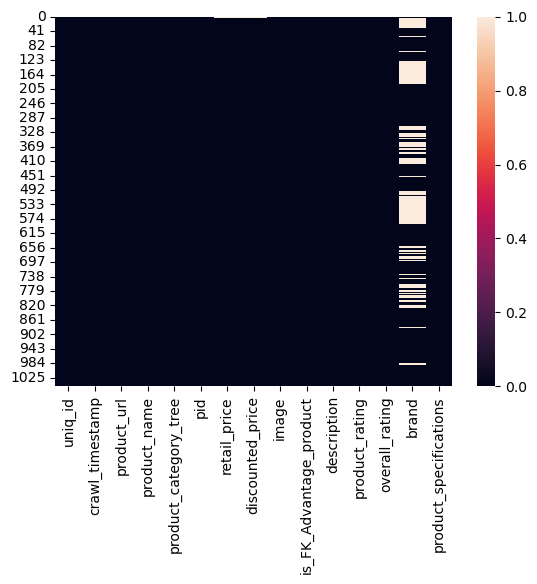

In [8]:
sns.heatmap(df.isnull());

### Traitement de la fonctionnalité "product_category_tree"

In [94]:
df.duplicated(subset="product_category_tree").sum()

408

In [10]:
df_cat = df.groupby('product_category_tree')
df_cat.first()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
product_category_tree,,,,,,,,,,,,,,
"[""Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol...""]",6325bf868b9040a0599f257aba42e9e0,2016-03-03 11:29:08 +0000,http://www.flipkart.com/doraemon-gift-family-c...,Doraemon Gift Family Ceramic Coffee Mug Multic...,DECEG7K7Y3URGWXH,399.0,280.0,6325bf868b9040a0599f257aba42e9e0.jpg,False,Specifications of Doraemon Gift Family Ceramic...,No rating available,No rating available,Doraemon Gift Family Ceramic Coffee Mug,"{""product_specification""=>[{""key""=>""Sales Pack..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames""]",fd10586bf7f01bc57e0c5364d4b2c3f7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/cocovey-metal-photo-fr...,Cocovey Metal Photo Frame,PHFEBZ2GBSK3U43Z,749.0,549.0,fd10586bf7f01bc57e0c5364d4b2c3f7.jpg,False,"Cocovey Metal Photo Frame (Photo Size - 6*4, 1...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames""]",6eabdbbbffdfae86c3c5177ba0f96ea7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/indha-craft-cloth-phot...,Indha Craft Cloth Photo Frame,PHFDWUHW25WAWXHY,300.0,132.0,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,False,Indha Craft Cloth Photo Frame (Photo Size - 12...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> MH Photo Frames""]",d06bb04b096c77dc3302eaf2db336f96,2015-12-31 09:19:31 +0000,http://www.flipkart.com/mh-mdf-photo-frame/p/i...,MH MDF Photo Frame,PHFEE9ZQGBXX5NYY,999.0,899.0,d06bb04b096c77dc3302eaf2db336f96.jpg,False,Buy MH MDF Photo Frame for Rs.899 online. MH M...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Wood Beauty Photo Frames""]",f79c9db3abd7faca714c92aeba9b6728,2015-12-31 09:19:31 +0000,http://www.flipkart.com/wood-beauty-photo-fram...,Wood Beauty Wood Photo Frame,PHFEEDJREU4HHEJG,650.0,450.0,f79c9db3abd7faca714c92aeba9b6728.jpg,False,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Frame Mate..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[""Watches >> Wrist Watches >> Yves Bertelin Wrist Watches >> Yves Bertelin YBSCR557 Analog Watch - For Women""]",4d2e9f36823bad0f6fe8c6b19bb92bdb,2016-04-24 18:34:50 +0000,http://www.flipkart.com/yves-bertelin-ybscr557...,Yves Bertelin YBSCR557 Analog Watch - For Women,WATEHYHJZDVZXNHZ,6950.0,3475.0,4d2e9f36823bad0f6fe8c6b19bb92bdb.jpg,False,Specifications of Yves Bertelin YBSCR557 Analo...,No rating available,No rating available,Yves Bertelin,"{""product_specification""=>[{""key""=>""Mechanism""..."
"[""Watches >> Wrist Watches >> fastrack Wrist Watches""]",653826cd53f1d9e2c086c0ac7846ef70,2015-12-04 07:25:36 +0000,http://www.flipkart.com/fastrack-38015pl01-ana...,"fastrack 38015PL01 Analog Watch - For Men, Boys",WATE9WKSHRYTM2PP,2495.0,2495.0,653826cd53f1d9e2c086c0ac7846ef70.jpg,False,"fastrack 38015PL01 Analog Watch - For Men, Bo...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Chronograp..."
"[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch - For Girls, Women""]",64a9d0488652194fd8e879d5e6dc8015,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-149-analog-...,"palito PLO 149 Analog Watch - For Girls, Women",WATEHZP3ZA9YT99G,1500.0,199.0,64a9d0488652194fd8e879d5e6dc8015.jpg,False,Specifications of palito PLO 149 Analog Watch ...,No rating available,No rating available

In [11]:
#Diviser le contenu de la colonne sur '>>' et récupérer le premier élément = la catégorie principale du produit
df['category'] = df['product_category_tree'].str.split('>>').str.get(0).str.strip()

# Suppression de la ponctuation indésirable de la colonne de catégorie
df['category'] = df['category'].str.extract(r'^\["([^"]+)')

In [12]:
# Nombre de catégories de produits
category_count = df['category'].value_counts()

In [95]:
category_count 

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

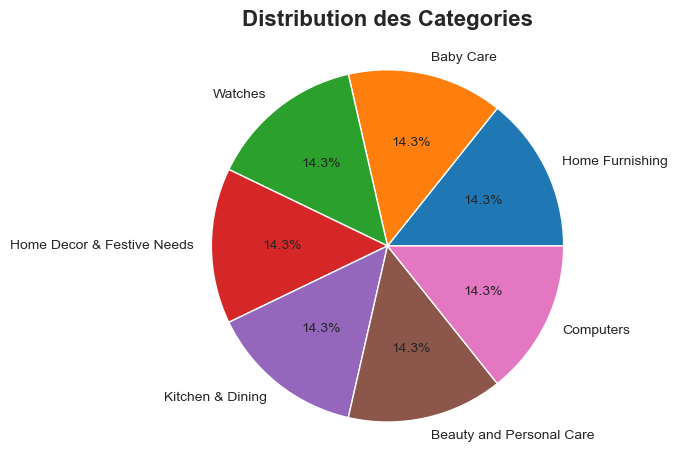

In [14]:
# La distribution par categorie
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%')
plt.title('Distribution des Categories',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 

plt.show()

Il y a sept grandes catégories de produits

## Pre traitement

## Exploration des données


In [15]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wall

In [16]:
df_t = df 
df_t.shape

(1050, 16)

In [17]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

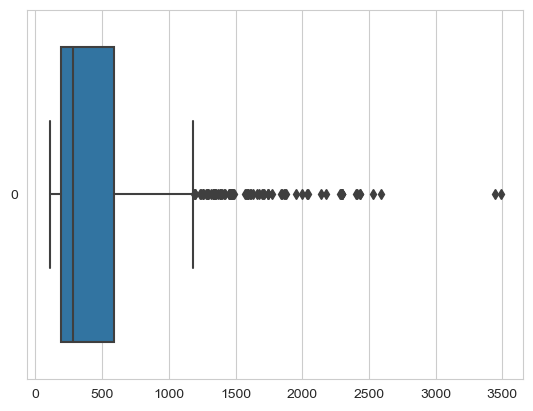

In [18]:
tmp = df.description.str.len()
sns.boxplot(tmp, orient='h');

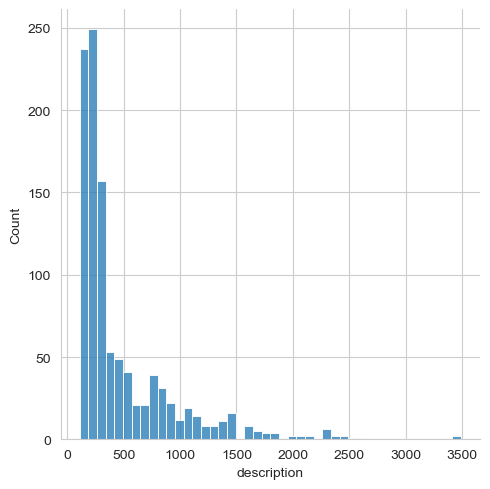

In [19]:
sns.displot(tmp);

In [21]:
df_long = df["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [22]:
df.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,275
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,268
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,817
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >

In [23]:
df_samp = df.sample(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
261,273982a65b9c7dabe56c8345552bfad7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/pristine-hard-anodised...,Pristine Hard Anodised Kadhai 2 L,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",PTPE7FFJTHJDMDB5,1260.0,899.0,273982a65b9c7dabe56c8345552bfad7.jpg,False,Pristine Hard Anodised Kadhai 2 L (Aluminium)\...,No rating available,No rating available,Pristine,"{""product_specification""=>[{""key""=>""Pan Type"",...",Kitchen & Dining,1597
949,f41761a931135c6c043c7e04abda41b0,2016-01-01 13:15:34 +0000,http://www.flipkart.com/welhouse-geometric-dou...,Welhouse Geometric Double Blanket Black,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAEEERTXBGBWYS8,1599.0,1049.0,f41761a931135c6c043c7e04abda41b0.jpg,False,Buy Welhouse Geometric Double Blanket Black at...,No rating available,No rating available,Welhouse,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,128
21,f74476ba64365d97a5be7d375cbf4c7a,2015-12-04 07:25:36 +0000,http://www.flipkart.com/now-sp-ethnic-analog-w...,Now SP-ETHNIC Analog Watch - For Boys,"[""Watches >> Wrist Watches >> Now Wrist Watches""]",WATECDB6HPXBVXCF,600.0,600.0,f74476ba64365d97a5be7d375cbf4c7a.jpg,False,Now SP-ETHNIC Analog Watch - For Boys - Buy N...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,247
877,c943647eee4de99fc1b4e233b9a7f47d,2015-12-20 08:26:17 +0000,http://www.flipkart.com/nkp-cotton-bath-towel/...,Nkp Cotton Bath Towel,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWEBZYHA6ZFBWK4,599.0,549.0,c943647eee4de99fc1b4e233b9a7f47d.jpg,False,Buy Nkp Cotton Bath Towel at Rs. 549 at Flipka...,No rating available,No rating available,Nkp,"{""product_specification""=>[{""key""=>""Material"",...",Home Furnishing,109
808,f9f9cd4297b6667488785c2794a754f5,2015-12-12 11:46:53 +0000,http://www.flipkart.com/mxofere-combo-jasmine-...,Mxofere Combo Jasmine Papaya Almond Honey Oran...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEBVA88B8NEHGV,285.0,285.0,f9f9cd4297b6667488785c2794a754f5.jpg,False,Mxofere Combo Jasmine Papaya Almond Honey Oran...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Organic Ty...",Beauty and Personal Care,1867
626,73901494efea71869576898c68b5eee4,2016-03-05 16:23:23 +0000,http://www.flipkart.com/ville-style-polyester-...,Ville Style Polyester Maroon Floral Eyelet Doo...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEGGZFH8XWXYEA,999.0,399.0,73901494efea71869576898c68b5eee4.jpg,False,Key Features of Ville Style Polyester Maroon F...,No rating available,No rating available,Ville Style,"{""product_specification""=>[{""key""=>""Reversible...",Home Furnishing,974
370,b42a9b597a3a3dc8f428e2e2323e9aff,2015-12-01 06:13:00 +0000,http://www.flipkart.com/anna-andre-paris-flora...,Anna Andre Paris Floralina & Red Horizon Combo...,"[""Beauty and Personal Care >> Fragrances >> De...",CAGDTN27DEWJYUHK,355.0,249.0,b42a9b597a3a3dc8f428e2e2323e9aff.jpg,False,Flipkart.com: Buy Anna Andre Paris Floralina &...,4,4,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,197
688,bc2aaae47829fd5825f6cc2ec51c2c5f,2015-12-31 09:19:31 +0000,http://www.flipkart.com/whiteherbs-ultra-prote...,Whiteherbs Ultra Protection Sunscreen Lotion -...,"[""Beauty and Personal Care >> Body and Skin Ca...",SNRE82YYYKFZFACZ,450.0,270.0,bc2aaae47829fd5825f6cc2ec51c2c5f.jpg,False,Flipkart.com: Buy Whiteherbs Ultra Protection ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Quantity"",...",Beauty and Personal Care,209
548,2541b59d54a3a9f2681c0049f7ddd85c,2016-01-07 05:50:25 +0000,http://www.flipkart.com/timewel-1100-n145-anal...,Timewel 1100-N145 Analog Watch - For Men,"[""Watc

In [24]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: 273982a65b9c7dabe56c8345552bfad7
Pristine Hard Anodised Kadhai 2 L (Aluminium)
                         Price: Rs. 899
				
			PRISTINE, Manufacturers of a range of Gourmet Cookware carries an experience of over two decades & has been successfully exporting to The Americas, Europe, Australia. The organization is ISO Certified having state of the art manufacturing facility spread over an area of 1,50,000 sq.feet.All products are manufactured with precise workmanship & pass through stringent quality control tests & checks. We deliver Quality products to our customers at factory prices. All products are packed in attractive gift boxes making it an ideal gifting solution as well.Our efforts are towards making the Kitchen a smarter place enhancing convenience, reduce time spent & reflect modern lifestyles.Our Mission: �To provide Quality Products at Affordable Prices.�
PRISTINE, Manufacturers of a range of Gourmet Cookware carries an experience of over two decades & has been successfully 

## PNL ( Traitement du Langage Naturel)
## Bag of word

### Stopwords 
Consiste à enlever les mots vides(qui n'apportent rien), les ponctuations, les caractères spéciaux etc...

In [25]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Nettoyage du feature "description"

In [26]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [27]:
df_t["description"].iloc[2]

'Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model N

In [28]:
df_t["description"].iloc[1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

In [29]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [30]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

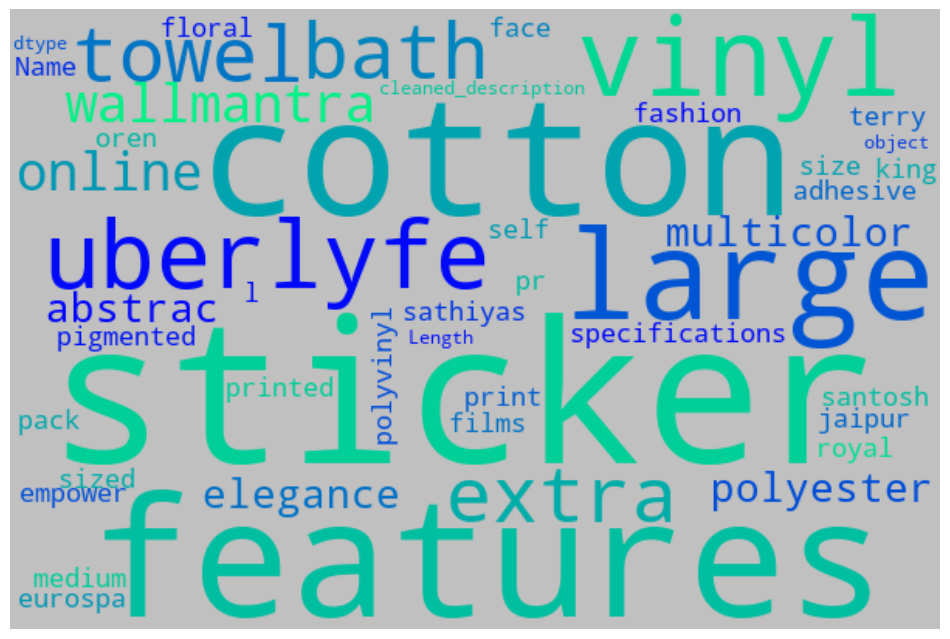

In [122]:
cloud=WordCloud(background_color='silver', colormap="winter", width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [32]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Tokenization
La tokenization consiste à découper un texte en parties plus petites appelées tokens
Lorsque nous divisons le texte en phrases, il s'agit de la tokenisation des phrases. Pour les mots, c'est la tokenisation des mots.

In [33]:
from nltk.tokenize import word_tokenize
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [34]:
df_t["tokenized"]

0       [features, elegance, polyester, multicolor, ab...
1       [specifications, sathiyas, cotton, bath, towel...
2       [features, eurospa, cotton, terry, face, towel...
3       [features, santosh, royal, fashion, cotton, pr...
4       [features, jaipur, print, cotton, floral, king...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, online, uber...
Name: tokenized, Length: 1050, dtype: object

### Lemmatization 
La lemmatisation est le processus de remplacement d'un mot par sa racine ou son mot principal appelé lemme. Le but est de réduire les formes flexionnelles à une forme de base commune. 

In [35]:
from nltk.stem import WordNetLemmatizer 

In [36]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [37]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [38]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [39]:
df_t.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"[features, elegance, polyester, multicolor, ab...","[feature, elegance, polyester, multicolor, abs...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"[specifications, sathiyas, cotton, bath, towel...","[specifications, sathiyas, cotton, bath, towel...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"[features, eurospa, cotton, terry, face, towel...","[feature, eurospa, cotton, terry, face, towel,...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"[features, santosh, royal, fashion, cotton, pr...","[feature, santosh, royal, fashion, cotton, pri...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"[features, jaipur, print, cotton, floral, king...","[feature, jaipur, print, cotton, floral, king,...",feature jaipur print cotton floral king size d...,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2432,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive s

In [40]:
df_t.to_csv('df_t.csv', index=False)

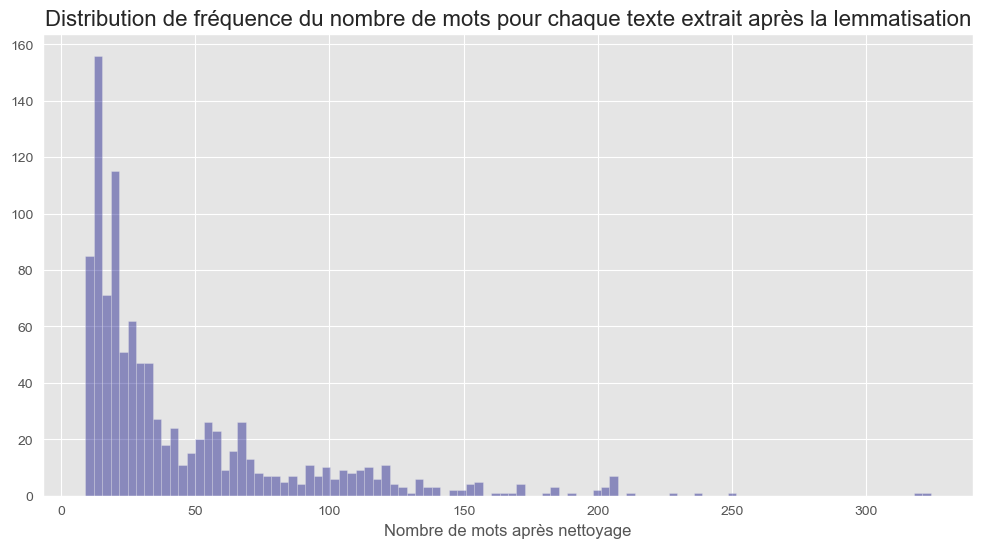

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [42]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

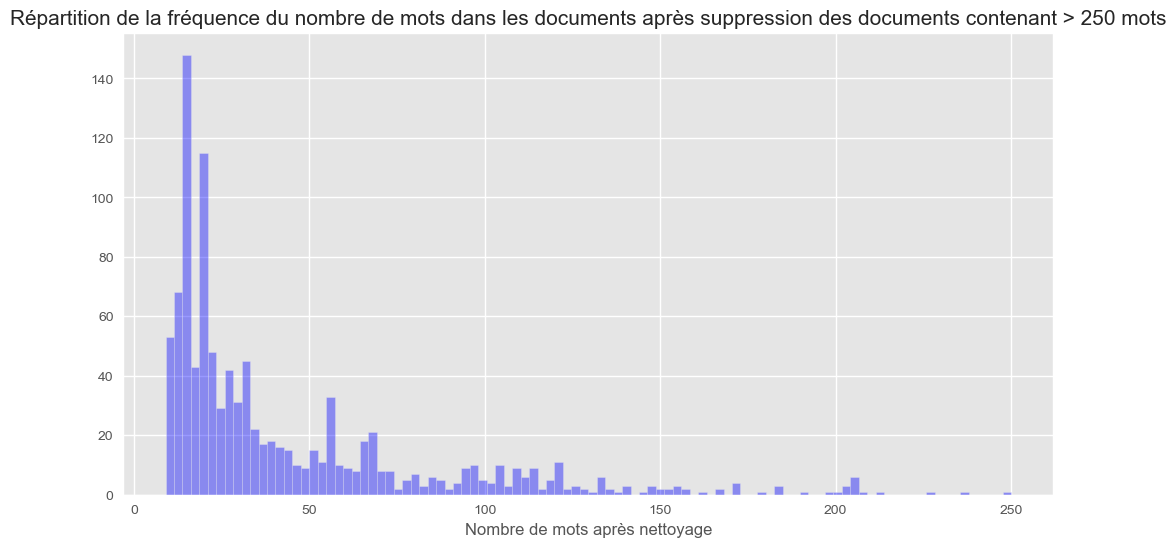

In [97]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

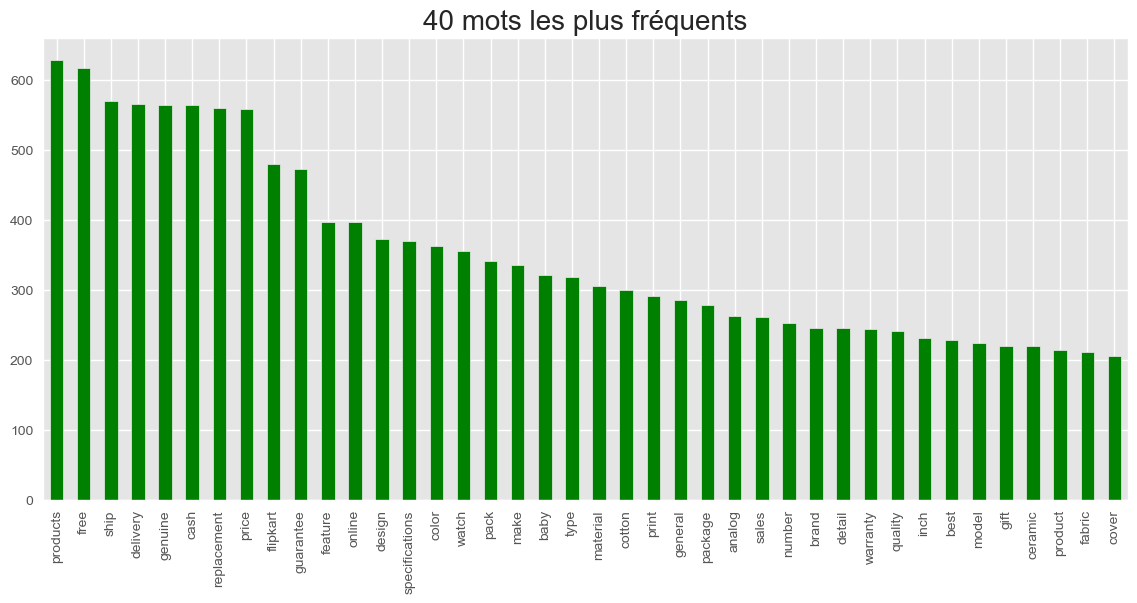

In [98]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:40]
freq.plot(kind="bar", color = "green")
plt.title("40 mots les plus fréquents",size=20);

### TF-IDF (Term frequency-inverse document frequency)
la Fréquence du Terme-la Fréquence Inverse du Document.  Le TF détermine la fréquence relative d’un mot ou d’une combinaison de mots dans un document, L'IDF est une valeur qui mesure la signification d'un terme en fonction de sa distribution et de son utilisation dans l'ensemble des documents : plus un terme a de potentiel, plus l’Inverse Document Frequency est élevée.

In [45]:
tfidf = TfidfVectorizer() 
# get tf-df values
result = tfidf.fit_transform(df_t["lemmatize_joined"])

In [47]:
# Converting each sequence of words into a single string
corpus = df_t['lemmatize_joined']

# Defining the vectorizer
vectorizer = TfidfVectorizer()

# Fitting it to the string 
vectorizer.fit(corpus)

# Transforming the corpus into a TF-IDF matrix
tfidf_matrix = vectorizer.transform(corpus)

# Converting the TF-IDF matrix to a df
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


In [48]:
df_tfidf

,aapno,aari,aarika,abide,abilities,ability,abkl,able,abroad,absolute,...,zero,zikrak,zinc,zingalalaa,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ACP : réduction de dimension

In [49]:
from sklearn.decomposition import PCA

In [50]:
n_components = 2
pca = PCA(n_components=n_components)

# Fitting to the df_tfidf
pca_result = pca.fit_transform(df_tfidf)

# New df for the results 
df_pca = pd.DataFrame(data=pca_result, columns=["PC{}".format(i+1) for i in range(n_components)])

In [51]:
df_pca

,PC1,PC2
0,-0.201817,-0.013003
1,-0.188942,-0.006644
2,-0.189502,-0.009583
3,-0.217456,0.002016
4,-0.230630,-0.007385
...,...,...
1043,-0.138621,0.002570
1044,-0.174679,-0.000899
1045,-0.018493,-0.042745
1046,0.007900,-0.063301


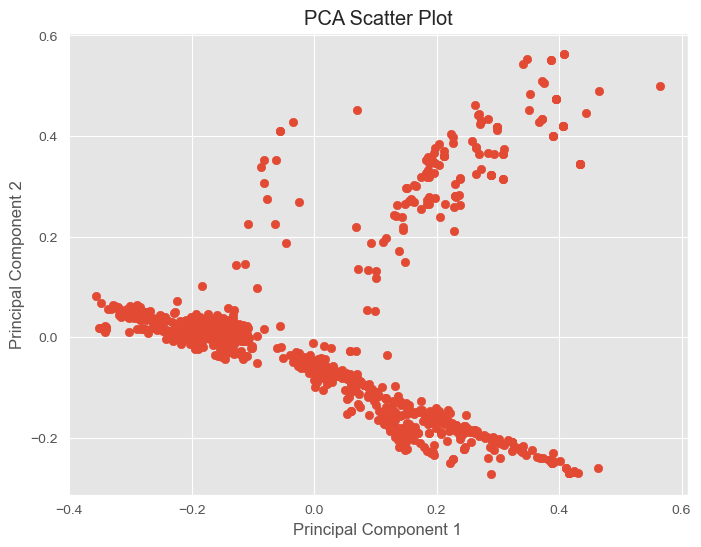

In [52]:
# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

## T-sne visualization avec TF-IDF

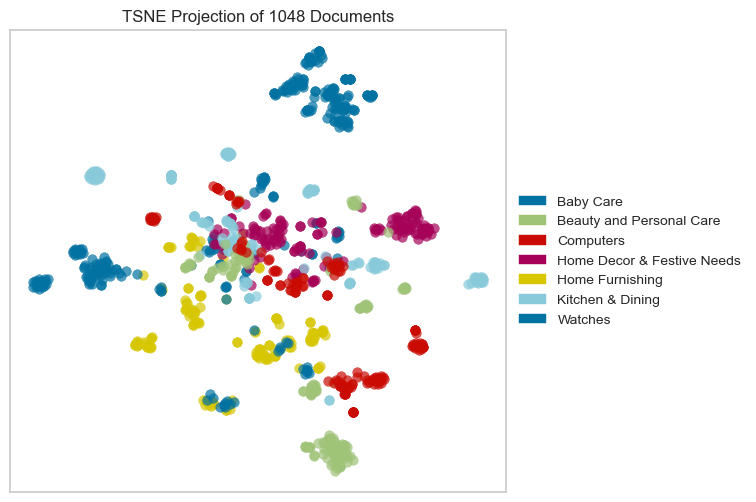

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
# Chargement des données et création des vecteurs
corpus = df_t.lemmatize_joined
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)
y = df_t.category
# Visualisation 2D des vecteurs créés
plt.figure(figsize=(8, 6))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show();

## Kmeans clustering et représentation visuelle du T-sne avec TF-ID

In [60]:
from sklearn.cluster import KMeans

In [57]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_t.lemmatize_joined)

In [58]:
num_clusters = 7  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Assign cluster labels to incidents
cluster_labels = kmeans.labels_


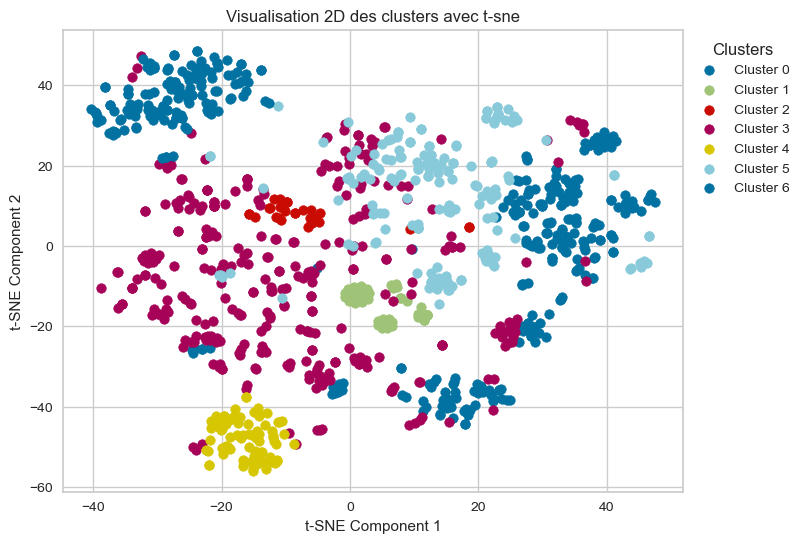

In [59]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())
# Visualize clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(
        X_tsne[cluster_labels == i, 0],
        X_tsne[cluster_labels == i, 1],
        label=f"Cluster {i}",
    )
plt.title("Visualisation 2D des clusters avec t-sne")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
plt.show()

#### ARI score of categories vs  clusters 

In [61]:
ari = adjusted_rand_score(df['category'], cluster_labels)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.24836839785506737


## Word2Vec

In [62]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action='ignore')

In [63]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df_t['category_encoded'] = label_encoder.fit_transform(df_t['category'])


In [64]:
model1 = gensim.models.Word2Vec(df_t.lemmatize_joined, min_count=1,
                                vector_size=100, window=5)

In [65]:
# Création d'une liste des phrases 
sentences = df_t.lemmatize_joined.tolist()
# Entraînement du modèle 
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# stocker les vecteurs de phrases
sentence_vectors = []
# Boucle des phrases
for sentence in sentences:
    sentence_vector = []
    # Parcourir chaque mot de la phrase et obtenir son vecteur
    for word in sentence:
        if word in model.wv:
            sentence_vector.append(model.wv[word])
    # Calculer le vecteur moyen de la phrase
    if sentence_vector:
        mean_vector = np.mean(sentence_vector, axis=0)
        sentence_vectors.append(mean_vector)

# Création d'un DataFrame à partir des vecteurs obtenus
df_sentence_vectors = pd.DataFrame(sentence_vectors, index=df_t['lemmatize_joined'],
                                   columns=[f'feature_{i+1}' for i in range(100)])


In [66]:
len(df_sentence_vectors)

1048

In [67]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the word_vectors_df
tsne_result_wv = tsne.fit_transform(df_sentence_vectors)

# Création du DataFrame pour les résultats t-SNE
df_tsne_wv = pd.DataFrame(data = tsne_result_wv, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [68]:
df_tsne_wv

,TSNE1,TSNE2
0,11.397936,-6.100890
1,34.300713,12.672494
2,7.565470,-0.326077
3,12.701551,23.612141
4,9.645802,22.556185
...,...,...
1043,11.191317,-11.490863
1044,-9.004853,10.834198
1045,-5.273525,-15.062790
1046,-12.627151,-2.786290


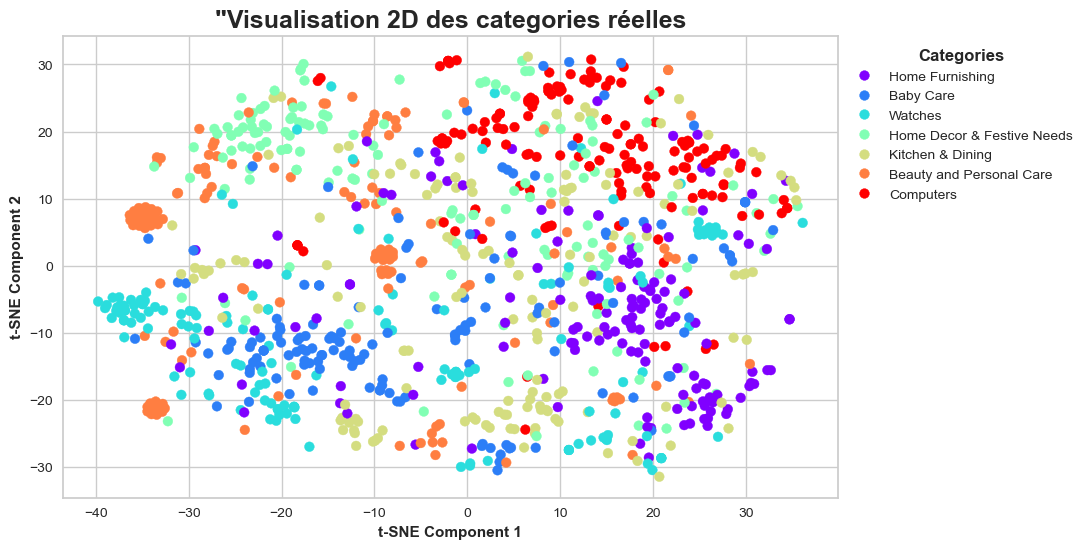

In [69]:
# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_tsne_wv['TSNE1'], df_tsne_wv['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('t-SNE Component 1', fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontweight = 'bold')
plt.title('Visualisation 2D des categories réelles', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the T-sne on Word2Vec 

In [70]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_wv[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_wv = kmeans.labels_

# Converting to df
df_tsne_wv['Cluster'] = cluster_labels_wv

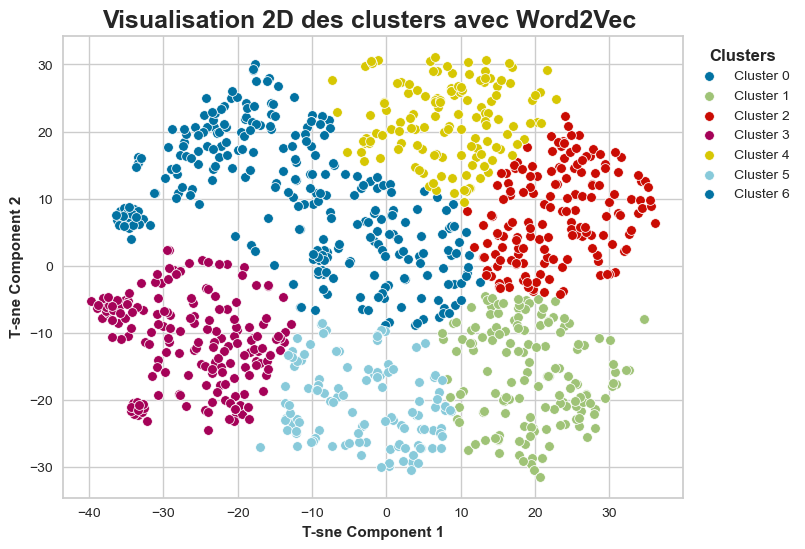

In [71]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_wv)):
    cluster_indices = np.where(cluster_labels_wv == label)
    sns.scatterplot(data=df_tsne_wv.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('Visualisation 2D des clusters avec Word2Vec ', fontweight ='bold', fontsize=18)
# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')
plt.show()

#### ARI score of categories vs  clusters 

In [72]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_wv)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.14372097660538583


## BERT (Bidirectional Encoder Representations from Transformers)

In [74]:
import torch

In [75]:
# Setting the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Setting the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [76]:
# Fonction pour encoder le texte à l'aide du tokenizer
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask)
        
    # Calculating the mean embedding of the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim = 1)
    
    # Converting the embeddings to a list and return
    return embeddings.tolist()[0]

In [77]:
# Applying the function to the lemmatized text
df_bert = df_t['lemmatize_joined'].apply(get_bert_embeddings)

In [78]:
# Transforming to df
df_bert_fin = pd.DataFrame(df_bert)

In [79]:
df_bert_fin

,lemmatize_joined
0,"[0.04804511368274689, 0.046610839664936066, 0...."
1,"[0.18314212560653687, -0.02782324329018593, 0...."
2,"[0.007824835367500782, 0.0022673725616186857, ..."
3,"[0.18816757202148438, -0.03589947521686554, 0...."
4,"[0.25443196296691895, 0.02988302707672119, 0.6..."
...,...
1045,"[-0.12494365870952606, 0.2245059758424759, 0.5..."
1046,"[-0.3881279528141022, 0.0947309136390686, 0.59..."
1047,"[0.19897940754890442, -0.1123645231127739, 0.4..."
1048,"[0.05565405637025833, -0.03943667933344841, 0...."


In [80]:
# Transforming to a list
df_bert_list = pd.DataFrame(df_bert_fin['lemmatize_joined'].to_list())

# Splitting the values within the columns using comma delimiter
df_bert_conc = pd.concat([df_bert_list[col].astype(str).str.split(',', expand=True) for col in df_bert_list.columns], axis=1)

# Renaming columns starting from 0
df_bert_conc.columns = [str(i) for i in range(len(df_bert_conc.columns))]

# Displaying the resulting DataFrame with separate columns
df_bert_conc

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.04804511368274689,0.046610839664936066,0.7873408198356628,-0.12329040467739105,0.4309496283531189,0.007683826144784689,0.09294295310974121,0.0586133636534214,-0.019880129024386406,-0.3061487674713135,...,-0.02509152516722679,-0.4458596706390381,0.09960231184959412,0.12727144360542297,0.11184434592723846,0.08268458396196365,-0.36888936161994934,0.022447124123573303,-0.07715581357479095,-0.13652800023555756
1,0.18314212560653687,-0.02782324329018593,0.5348010063171387,0.12005120515823364,0.19718357920646667,0.005752130411565304,0.1744929552078247,-0.0077481321059167385,-0.1438332498073578,-0.16580861806869507,...,-0.037798408418893814,-0.1241784542798996,0.09746749699115753,-0.02511741779744625,0.15218763053417206,0.09989475458860397,-0.37452033162117004,-0.1360265165567398,-0.18188416957855225,0.15960907936096191
2,0.007824835367500782,0.0022673725616186857,0.5762696266174316,-0.03653585910797119,0.31263652443885803,-0.00377508532255888,-0.10784756392240524,0.1831032633781433,-0.13834963738918304,-0.27761560678482056,...,-0.13666260242462158,-0.23302115499973297,0.14451773464679718,0.044191040098667145,0.16111531853675842,0.0901680737733841,-0.46205276250839233,-0.09621627628803253,-0.2085743099451065,0.03215252235531807
3,0.18816757202148438,-0.03589947521686554,0.7175165414810181,0.03351376950740814,0.3220038115978241,-0.23248618841171265,-0.08416551351547241,0.20604532957077026,-0.05749811232089996,-0.0063233403488993645,...,0.10812373459339142,-0.14715039730072021,0.13632744550704956,-0.09044045209884644,0.10717826336622238,0.17352595925331116,-0.4426063895225525,-0.02190212905406952,0.012332340702414513,-0.13386133313179016
4,0.25443196296691895,0.02988302707672119,0.6154786348342896,-0.08420141041278839,0.3025406301021576,-0.18655537068843842,-0.017988743260502815,0.2989371120929718,0.06491528451442719,-0.11216564476490021,...,0.07192430645227432,-0.24966850876808167,0.19995726644992828,0.020121267065405846,-0.001570894499309361,0.12087883055210114,-0.5629705190658569,0.02269718050956726,-0.002450201427564025,-0.13916899263858795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,-0.12494365870952606,0.2245059758424759,0.5290270447731018,-0.24495460093021393,0.5421457290649414,-0.25958842039108276,0.07284571975469589,0.1775914877653122,0.11515384167432785,-0.20280544459819794,...,-0.35391008853912354,-0.39847052097320557,0.029629714787006378,0.25875604152679443,0.17134885489940643,-0.0071940189227461815,-0.5263594388961792,0.025801552459597588,-0.12162918597459793,0.05164889991283417
1044,-0.3881279528141022,0.0947309136390686,0.5905271768569946,-0.09127460420131683,0.43021684885025024,-0.2671785354614258,0.07687202841043472,0.23494316637516022,0.2785288393497467,-0.13544827699661255,...,-0.19953598082065582,-0.3414401113986969,0.045543357729911804,0.23730921745300293,-0.005389007274061441,-0.10120850056409836,-0.3924274444580078,0.013136238791048527,-0.11378566920757294,-0.19826146960258484
1045,0.19897940754890442,-0.1123645231127739,0.43280264735221863,0.08352876454591751,0.35356226563453674,-0.21194355189800262,-0.1824338734149933,0.5244327187538147,-0.18345008790493011,-0.042359355837106705,...,0.0016245096921920776,-0.4650023877620697,0.13862130045890808,0.006051506847143173,0.1336928904056549,-0.012780305929481983,-0.4313761293888092,0.05769456923007965,-0.045955248177051544,-0.1787092685699463
1046,0.05565405637025833,-0.03943667933344841,0.44159039855003357,0.12322184443473816,0.26278361678123474,-0.27610570192337036,-0.008135638199746609,0.28833839297294617,0.08566761016845703,-0.1690397560596466,...,0.0157596617937088,-0.5979921221733093,0.2989043593406677,-0.11364637315273285,0.15752452611923218,-0.23682673275470734,-0.5113663673400879,0.2509691119194031,-0.03593527525663376,-0.42000511288642883


### T-sne on BERT 

In [81]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_bert = tsne.fit_transform(df_bert_conc)

# Creating a new df for the results
df_tsne_bert = pd.DataFrame(data = tsne_result_bert, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

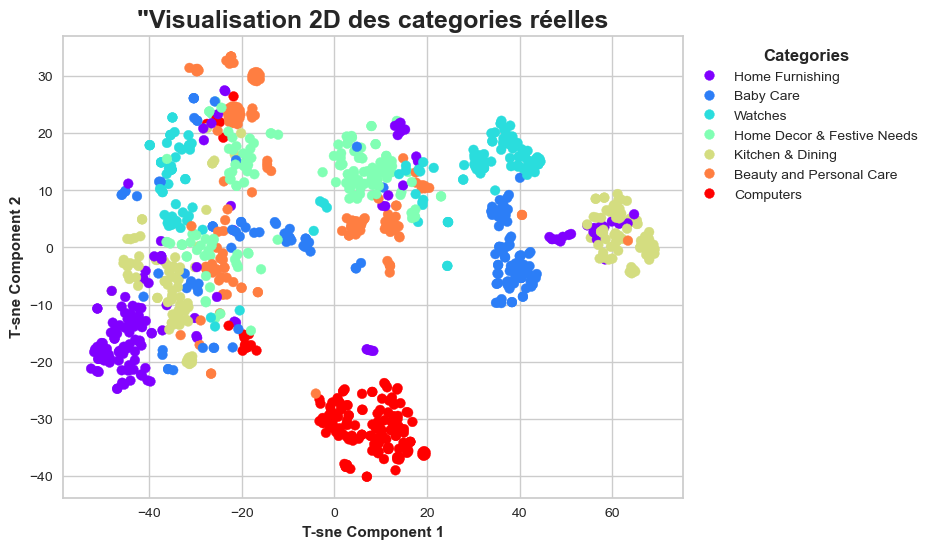

In [82]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_bert['TSNE1'], df_tsne_bert['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight = 'bold')
plt.ylabel('T-sne Component 2', fontweight = 'bold')
plt.title('"Visualisation 2D des categories réelles', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the t-SNE on BERT

In [83]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_bert[['TSNE1', 'TSNE2']])

# Retrieving cluster labels 
cluster_labels_bert = kmeans.labels_

# Converting to df
df_tsne_bert['Cluster'] = cluster_labels_bert

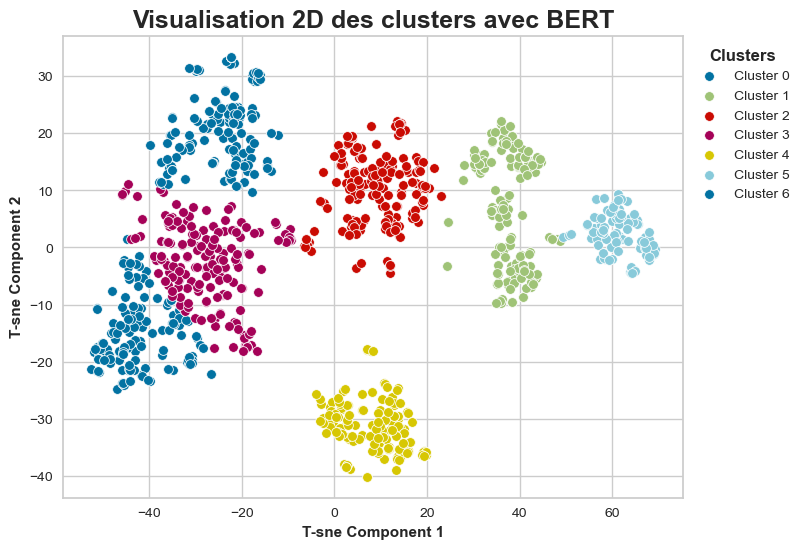

In [84]:
# Plot with a different color for each cluster 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_bert)):
    cluster_indices = np.where(cluster_labels_bert == label)
    sns.scatterplot(data=df_tsne_bert.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('Visualisation 2D des clusters avec BERT', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI scores of real categories vs clusters 

In [85]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_bert)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.3170999442820336


### USE (Universal Sentence Encoder)

In [86]:
import tensorflow_hub as hub

In [87]:
#Converting each sequence of words into a single string
sentences = df_t['lemmatize_joined'].apply(' '.join).values.astype('U')

# Getting and loading the URL for the USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(module_url)

# Creating a KerasLayer fro mthe loaded model
embedding_fn = hub.KerasLayer(use_model, input_shape=[], dtype=tf.string, trainable=False)

# Creating a sequential model with the embedding layer
embedding_model = tf.keras.Sequential([embedding_fn])

# Converting the sentences to a numpy array
sentences_array = np.array(sentences, dtype=object) 

# Generating the sentences with the embedding model
embeddings = embedding_model.predict(sentences_array)

# Transforming to df
embedding_df = pd.DataFrame(embeddings)

33/33 [==============================] - 1499s 45s/step


In [88]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.033529,0.005593,-0.033619,-0.019755,0.031313,0.052536,-0.018704,-0.045935,0.049436,0.006521,...,-0.004326,0.051562,0.043402,0.026941,-0.026880,-0.121074,0.035770,0.030475,0.007476,0.024988
1,-0.032931,-0.014672,-0.022670,0.030195,0.019436,0.043736,-0.004194,-0.075259,0.032070,0.010786,...,-0.012312,0.008845,0.030894,-0.015897,-0.045434,-0.107823,0.021592,0.024653,0.018462,0.021780
2,-0.038978,-0.002425,-0.021920,-0.014565,0.032739,0.053969,-0.021076,-0.048443,0.039901,0.009252,...,0.000215,0.041267,0.047461,0.023206,-0.029807,-0.113523,0.036356,0.034544,0.004563,0.015400
3,-0.032347,-0.016947,-0.025589,-0.010472,0.037240,0.067427,-0.020840,-0.054699,0.034560,0.015550,...,0.000262,0.026612,0.044138,0.010537,-0.039083,-0.118177,0.039734,0.032643,-0.001159,0.022624
4,-0.027723,-0.001744,-0.026327,-0.016045,0.038618,0.072632,-0.014721,-0.045618,0.042509,0.016353,...,-0.000673,0.040620,0.049864,0.019722,-0.031806,-0.114381,0.038945,0.036833,-0.001436,0.024166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,-0.032282,0.006135,-0.029129,-0.020111,0.016617,0.051452,-0.035046,-0.048416,0.041442,0.010120,...,-0.011877,0.062242,0.045373,0.023506,-0.029913,-0.113927,0.036121,0.032095,0.001256,0.032049
1044,-0.036440,0.002581,-0.026254,-0.027388,0.025824,0.045920,-0.018971,-0.043861,0.036792,0.005104,...,-0.006930,0.047469,0.045476,0.026839,-0.027651,-0.125578,0.035495,0.033867,0.012300,0.014856
1045,-0.038190,0.007773,-0.019618,0.034748,-0.003226,0.021599,-0.014132,-0.063171,0.017169,0.001429,...,-0.022366,-0.009080,0.023328,-0.009145,-0.065563,-0.089140,0.009566,0.000837,0.022488,0.011840
1046,-0.024200,0.000890,-0.022662,0.031434,-0.007697,0.011863,-0.000972,-0.059537,0.012374,-0.009132,...,-0.036260,-0.010704,0.028996,-0.013810,-0.061179,-0.102083,0.016745,0.018931,0.031388,0.003283


#### t-SNE on USE 

In [89]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_use = tsne.fit_transform(embedding_df)

# Create a new DataFrame for the t-SNE results
df_tsne_use = pd.DataFrame(data = tsne_result_use, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

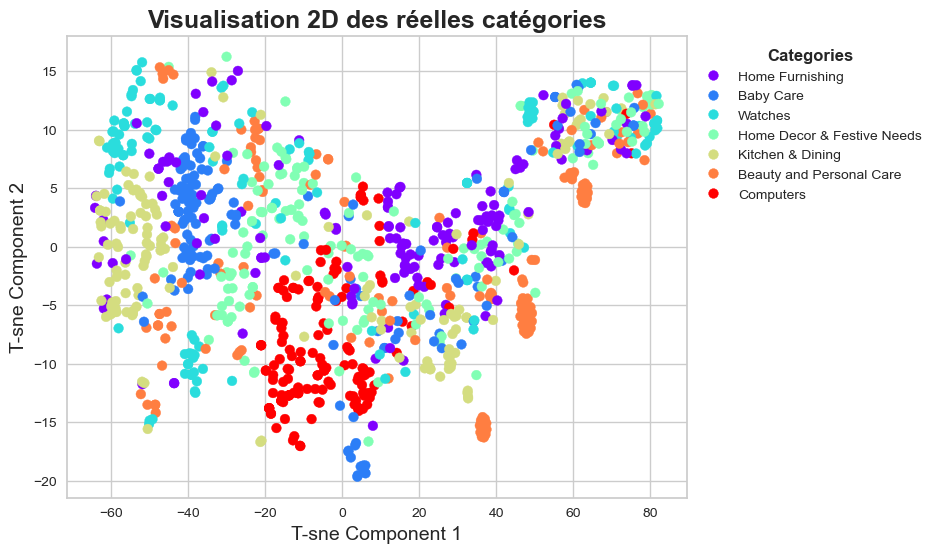

In [90]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_use['TSNE1'], df_tsne_use['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontsize=14)
plt.ylabel('T-sne Component 2', fontsize=14)
plt.title('Visualisation 2D des réelles catégories', fontweight ='bold', fontsize=18)
plt.show()

### Kmeans clustering and visual representation of the t-SNE on USE

In [91]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_use[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_use = kmeans.labels_

# Converting to df
df_tsne_use['Cluster'] = cluster_labels_use

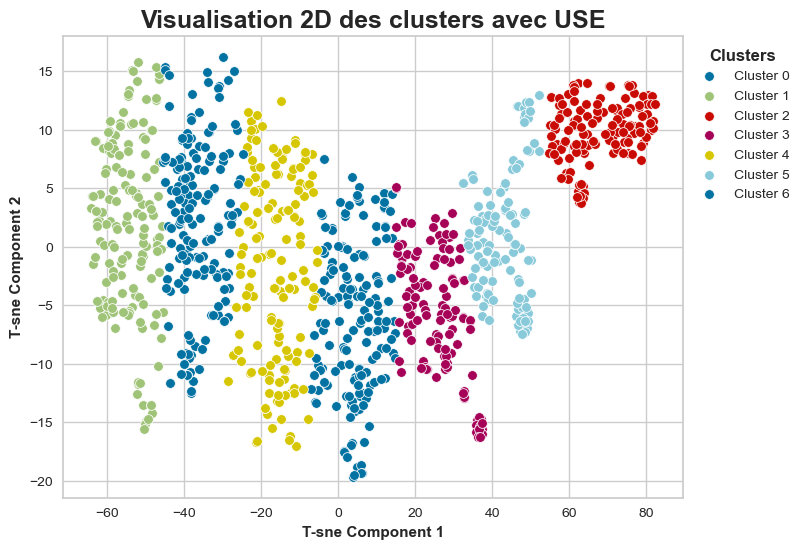

In [92]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_use)):
    cluster_indices = np.where(cluster_labels_use == label)
    sns.scatterplot(data=df_tsne_use.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('Visualisation 2D des clusters avec USE', fontweight ='bold', fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')
plt.show()

#### ARI score of categories vs clusters 

In [98]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_use)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.1267934810797711


Les étiquetages aléatoires ont un ARI proche de 0,0. 1.0 signifie correspondance parfaite